# Using Machine Learning to predict a topological invariant of superconductors

In this code we use machine learning (ML) methods to predict the topological invariant Bott index of disordered superconductors. If the Bott index is nonzero, the superconductor is topologically nontrivial and hosts Majorana quasiparticles. These Majorana states are known for their potential to be a building bloch for quantum computing. The precise calculation of the Bott index demands high computational resources. If we are able to predict this index using a ML method, we can save time and computational resources. 

The input data is extracted from Green's functions of the superconductors which I computed using a Fortran code. For each value of the chimical potential (denoted 'mu') and magnetic dilution (denoted 'p'), we have data of several realizations of superconductors. Our goal is to build the topological phase diagram of the Bott index ('B') as a function of mu and p. 

## Load data

In the following we first load the data of disorderless (p=0) superconductors, which we will use to visualize the Majorana modes. Then we load the data that we will use to train different ML models. We also load the data whose labels we will predict. We have data for mu ranging from -7 to 0 and p ranging from 0 to 1. Finally, we will recover the full phase diagram, which is known from the reference [Phys. Rev. B 100, 235102 (2019)].

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

####################################################################################################
#DEFINING DOMES OF THE DATA WHOSE LABELS WE WILL PREDICT
mu_c1=-4-math.sqrt(4-(1.2**2))
mu_c2=-4+math.sqrt(4-(1.2**2))
mu_c3=-math.sqrt(4-(1.2**2))
mu_c4=0

dome1 = np.array([[mu_c1,0],[-4,0.48],[mu_c2,0]]) 
fit_dome1 = np.poly1d(np.polyfit(dome1[:,0],dome1[:,1], 2))

dome2 = np.array([[mu_c3,0],[0,0.48],[-mu_c3,0]]) 
fit_dome2 = np.poly1d(np.polyfit(dome2[:,0],dome2[:,1], 2))

#B should be finite below the domes and vanish above them according to [Phys. Rev. B 100, 235102 (2019)].
def critical_line(x):
    condition1 = np.logical_and(mu_c1 <= x, x <= mu_c2)
    condition2 = np.logical_and(mu_c3 <= x, x <= mu_c4) 
    result = np.where(condition1, fit_dome1(x), 0)
    result = np.where(condition2, fit_dome2(x), result)
    return result

####################################################################################################
#LOAD THE DATA WITH p=0 ONLY
X_p0 = np.loadtxt("p0_varymu_square/Data/ALDOStxy.out") #features, the LDOS
mu_p0 = np.loadtxt("p0_varymu_square/Data/Amup.out")[:,0]
p_p0 = np.loadtxt("p0_varymu_square/Data/Amup.out")[:,1]
sample_size0=len(X_p0)

y_p0=np.zeros(sample_size0) #labels
for mu_i in range(sample_size0):
    if (mu_p0[mu_i]>=mu_c1) and (mu_p0[mu_i]<=mu_c2):
        y_p0[mu_i]=-1
    if (mu_p0[mu_i]>=mu_c3) and (mu_p0[mu_i]<=mu_c4):
        y_p0[mu_i]=2


####################################################################################################
#LOAD THE REST OF THE TRAINING DATA
N_folders_total=12
N_folders_train=9

for fold_i in range(N_folders_train):
    if (fold_i==0):
        X_train = np.loadtxt("varyp_varymu_square"+str(fold_i+1)+"/Data/ALDOStxy.out") #features to predict a label
        mu_train = np.loadtxt("varyp_varymu_square"+str(fold_i+1)+"/Data/Amup.out")[:,0]
        p_train = np.loadtxt("varyp_varymu_square"+str(fold_i+1)+"/Data/Amup.out")[:,1]
    else:
        X_train=np.concatenate((X_train,np.loadtxt("varyp_varymu_square"+str(fold_i+1)+"/Data/ALDOStxy.out")),axis=0)
        mu_train=np.concatenate((mu_train,np.loadtxt("varyp_varymu_square"+str(fold_i+1)+"/Data/Amup.out")[:,0]))
        p_train=np.concatenate((p_train,np.loadtxt("varyp_varymu_square"+str(fold_i+1)+"/Data/Amup.out")[:,1]))

N_mu=len(np.unique(mu_train))
N_p=len(np.unique(p_train))
N_grid=N_mu*N_p
N_d=int(len(mu_train)/N_grid)
print(N_d)

y_train=np.where(p_train<critical_line(mu_train),-1,0)
y_train=np.where(mu_c3<=mu_train,-2*y_train,y_train)

X_train=np.concatenate((X_p0,X_train))
y_t=np.concatenate((y_p0,y_train))

####################################################################################################
#LOAD THE TEST DATA 

for fold_i in range(N_folders_total-N_folders_train):
    if (fold_i==0):
        X_test = np.loadtxt("varyp_varymu_square"+str(N_folders_total-fold_i)+"/Data/ALDOStxy.out") #features to predict a label
        mu_test = np.loadtxt("varyp_varymu_square"+str(N_folders_total-fold_i)+"/Data/Amup.out")[:,0]
        p_test = np.loadtxt("varyp_varymu_square"+str(N_folders_total-fold_i)+"/Data/Amup.out")[:,1]
    else:
        X_test=np.concatenate((X_test,np.loadtxt("varyp_varymu_square"+str(N_folders_total-fold_i)+"/Data/ALDOStxy.out")),axis=0)
        mu_test=np.concatenate((mu_test,np.loadtxt("varyp_varymu_square"+str(N_folders_total-fold_i)+"/Data/Amup.out")[:,0]))
        p_test=np.concatenate((p_test,np.loadtxt("varyp_varymu_square"+str(N_folders_total-fold_i)+"/Data/Amup.out")[:,1]))

N_mu=len(np.unique(mu_test))
N_p=len(np.unique(p_test))
N_grid=N_mu*N_p
N_d=int(len(mu_test)/N_grid)
Nd_mu_p=N_d
print(N_d)

y_test=np.where(p_test<critical_line(mu_test),-1,0) 
y_test=np.where(mu_c3<=mu_test,-2*y_test,y_test) 



47
21


The variable X is the set of features and contains the local density of states (LDOS) of many superconductors. The variable y contains the corresponding labels, which are the Bott indexes. The Bott index is an integer number. We will use X_train and y_t to train the models. Then, we use the models to predict the labels of X_predict.

Before training ML models, let's visualize the LDOS for disorderless (p=0) data for B=0,-1 and 2, respectively.

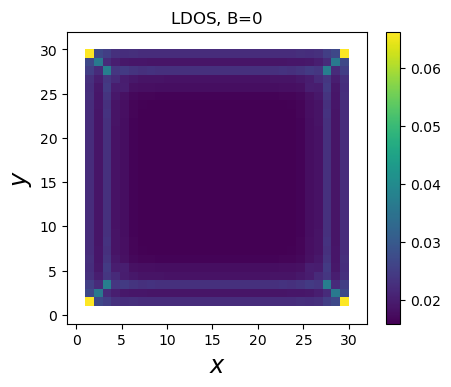

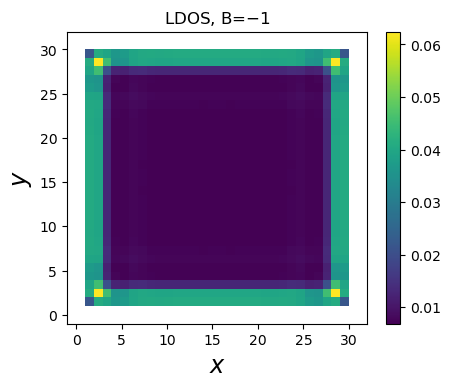

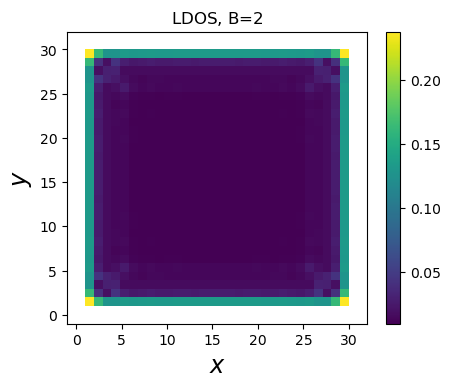

In [2]:
import math 
Bot=[0,-1,2]
LDOSa = X_p0[np.where(mu_p0==-2)]
LDOSb = X_p0[np.where(mu_p0==-5)]
LDOSc = X_p0[np.where(mu_p0==0)]
LDOS2=np.vstack((LDOSa,LDOSb,LDOSc))

nx=int(math.sqrt(len(X_p0[0])))
ny=nx

LDOS=np.zeros((nx,ny))

for idd in range(3) :
    ii=-1
    for iy in range(ny) :
        for ix in range(nx) :
            ii+=1
            LDOS[ix,iy]=LDOS2[idd,ii] 

    plt.figure(figsize=(5,4))
    plt.imshow(np.transpose(LDOS[:,:]),extent=[1,nx,1,ny], aspect='auto',origin='lower') 
    plt.colorbar()
    plt.title('LDOS'+', B=${}$'.format(Bot[idd]), loc='center')
    plt.xlabel('$x$', fontsize='xx-large')
    plt.ylabel("$y$", fontsize='xx-large')
    plt.xlim(-2+1,nx+1+1)
    plt.ylim(-2+1,ny+1+1)
    plt.subplots_adjust(left=0.15)  
    plt.subplots_adjust(bottom=0.15)
    plt.savefig('Data/fLDOS{}.png'.format(idd+1))  

From the figures above, we note that when the superconductor is topological (B=-1 and B=2), the LDOS is more intense at the edges. In the following, we train ML models to predict the label B.

## Train a classification model, validate and make predictions

Here we consider a LogisticRegression classification model. We then define the function 'Predict_Classification', which validates the model and predicts the label of X_predict.

In [3]:
y_train=np.ravel(y_t)

from sklearn.linear_model import LogisticRegression
reg = 0.01 # Set regularization rate
model = LogisticRegression(C=1/reg, solver='lbfgs', multi_class='auto', max_iter=10000).fit(X_train, y_train)

def Predict_Classification(model2,X_test2,y_test2):
    
    validate = model2.predict(X_test2)
    
    from sklearn.metrics import classification_report 
    print(classification_report(np.ravel(y_test2), validate))
    
    
    Bott_all2=np.zeros((N_mu,N_p,N_d)) 
    Bott_density2=np.zeros((N_mu,N_p))  
    Bott_tt = model2.predict(X_test2) 
    
    for i_mu,mu_i in enumerate(np.unique(mu_test)):
        for i_p,p_i in enumerate(np.unique(p_test)):
            var=np.intersect1d(np.where(mu_test==mu_i),np.where(p_test==p_i)) 
            Bott_t = Bott_tt[var]
            Bott_density2[i_mu,i_p]=Bott_t.mean()
            Bott_all2[i_mu,i_p,:]=Bott_t[:] 
    return Bott_density2,Bott_all2


Bott_density,Bott_all=Predict_Classification(model,X_test,y_test) 

              precision    recall  f1-score   support

          -1       0.96      0.86      0.91     11004
           0       0.97      0.99      0.98     59220
           2       0.95      0.95      0.95      5817

    accuracy                           0.97     76041
   macro avg       0.96      0.93      0.94     76041
weighted avg       0.97      0.97      0.97     76041



The accuracy of the model is 0.97 in the test dataset.  

### Plot figures

Here we present figures with the predictions of the ML models. The first figure is the topological phase diagram, which show the average Bott index as a function of mu and p. Other figures show, for fixed values of mu, the percentage of each Bott index value as a function of p.

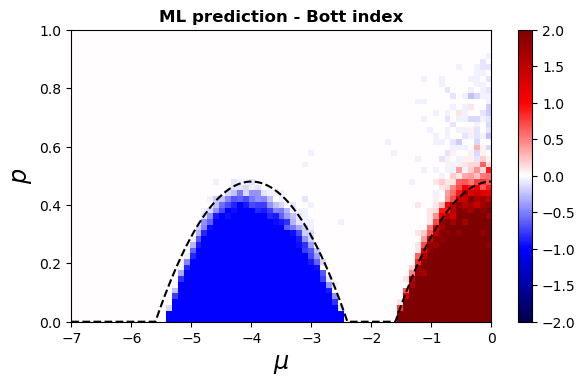

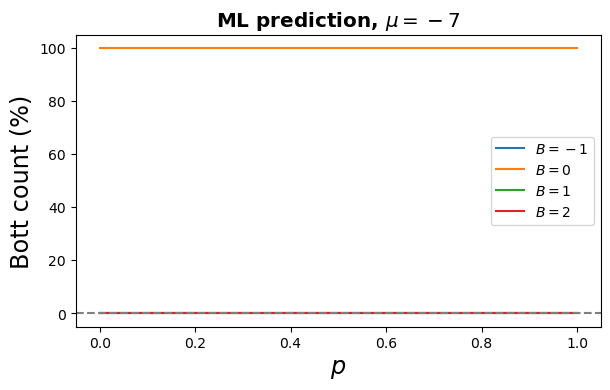

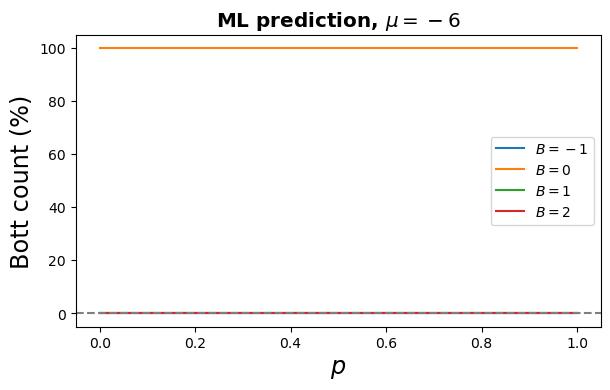

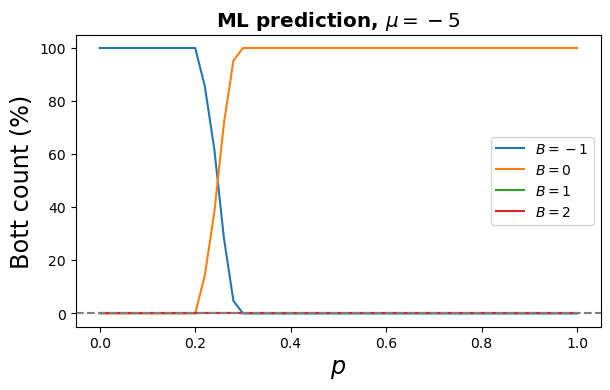

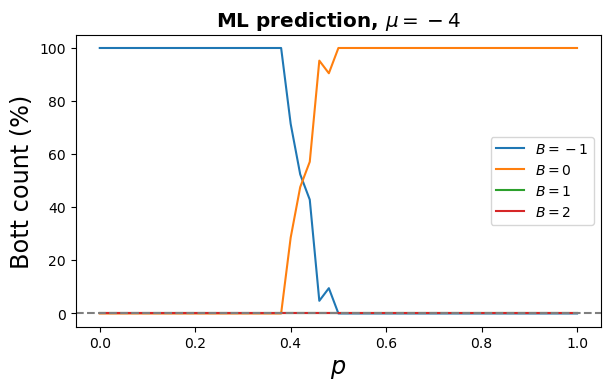

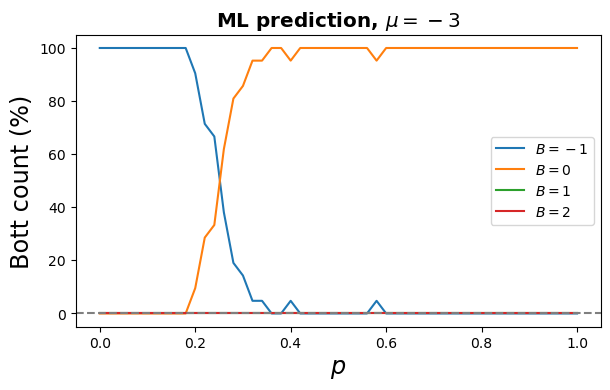

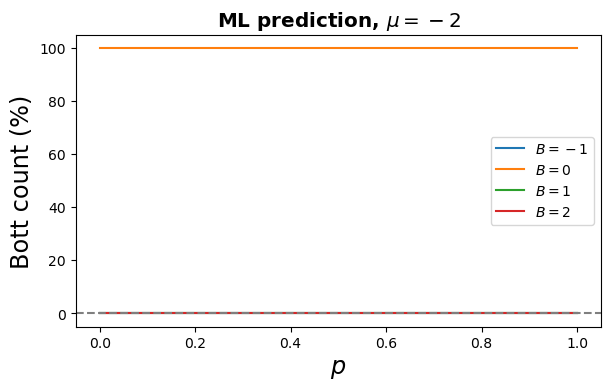

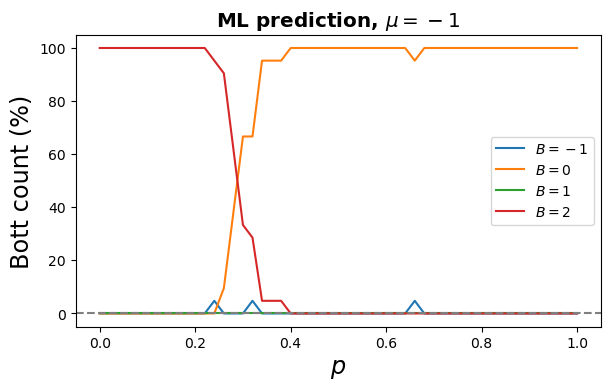

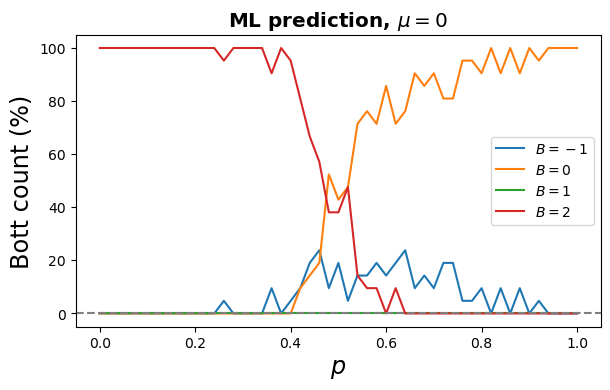

In [4]:
def Plots(Bott_density2,Bott_all2):
    min_Bott=int(np.nanmin(Bott_all2))
    max_Bott=int(np.nanmax(Bott_all2))
        
    #values of chimical potential mu:
    mu_step=1    
    mu_values=range(-7, 0+mu_step, mu_step)
    
    count_Bott=np.zeros((len(mu_values),N_p,max_Bott-min_Bott+1)) 
    B_values=range(min_Bott,max_Bott+1)
    for bval in range(-min_Bott+max_Bott+1):
        count_Bott[:,:,bval] = np.count_nonzero(Bott_all2[np.where(np.in1d(np.unique(mu_test),mu_values))[0]] == B_values[bval], axis=2) 
    
    plt.figure(figsize=(7,4))
    plt.imshow(np.transpose(Bott_density2[:,:]), extent=[min(mu_test),max(mu_test),min(p_test),max(p_test)],aspect='auto',origin='lower',cmap='seismic',vmin=-2, vmax=2) 
    plt.plot(np.arange(-7,0,0.01),critical_line(np.arange(-7,0,0.01)),'k--')
    plt.colorbar()
    plt.ylim(0,1)
    plt.title('ML prediction - Bott index', fontweight ="bold",loc='center')
    plt.xlabel('$\\mu$', fontsize='xx-large')
    plt.ylabel("$p$", fontsize='xx-large')
    plt.subplots_adjust(left=0.15)  
    plt.subplots_adjust(bottom=0.15)
    plt.savefig('Data/fig.png') 
    
    for mu_i in range(len(mu_values)): 
        plt.subplots(figsize=(7,4))
        for nn in range(max_Bott-min_Bott+1):
            plt.plot(np.unique(p_test),100*count_Bott[mu_i,:,nn]/N_d, label='$B={}$'.format(B_values[nn])) 
        plt.title('ML prediction, $\\mu={}$'.format(mu_values[mu_i]), fontsize='x-large',  fontweight ="bold")
        plt.legend(loc='right')
        plt.axhline(y = 0, color = 'tab:gray', linestyle = '--')
        plt.xlabel('$p$', fontsize='xx-large')
        plt.ylabel("Bott count (%)", fontsize='xx-large')
        plt.subplots_adjust(left=0.15)  
        plt.subplots_adjust(bottom=0.15)
        plt.savefig('Data/f{}.png'.format(mu_i+1))   

Plots(Bott_density,Bott_all)

The first figure shows the phase diagram. The Bott index should be B=0 above the black dashed lines and nonzero below them. These dashed lines represent topological transitions that we extracted from  [Phys. Rev. B 100, 235102 (2019)]. The B=2 area is larger than it should be, while the B=-1 area is smaller. Moreover, the last figure shows that, for mu=0, there is an interval of p values with a finite number of B=-1 counts. There should be no such interval with B=-1 for this value of mu.

## RandomForest

Next we try a RandomForest algorithm.

              precision    recall  f1-score   support

          -1       1.00      0.91      0.95     11004
           0       0.98      1.00      0.99     59220
           2       0.97      0.96      0.97      5817

    accuracy                           0.98     76041
   macro avg       0.98      0.95      0.97     76041
weighted avg       0.98      0.98      0.98     76041



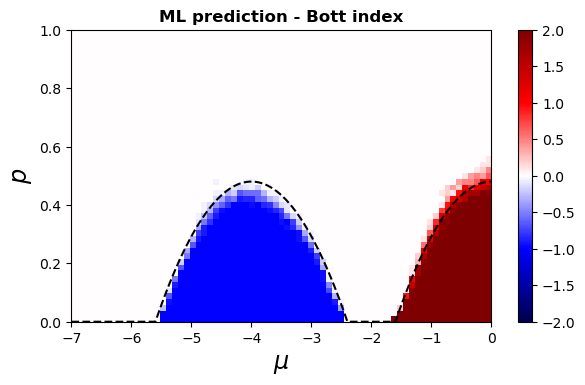

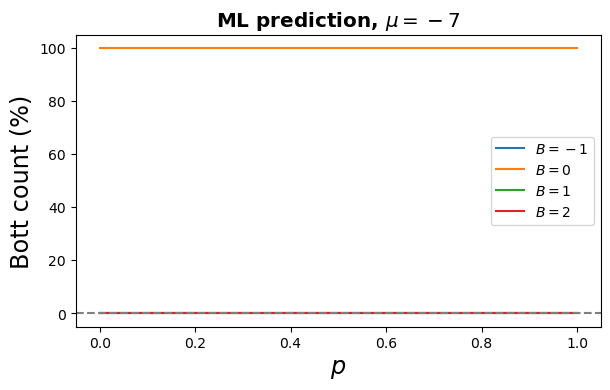

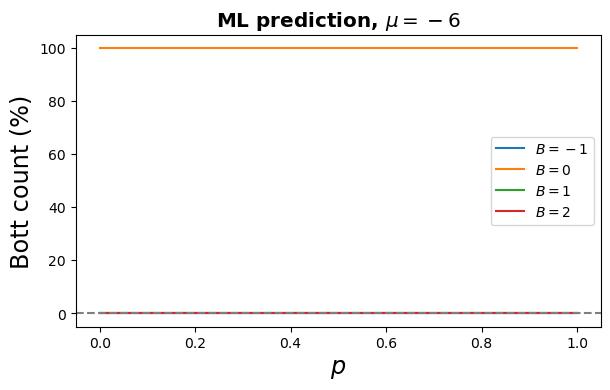

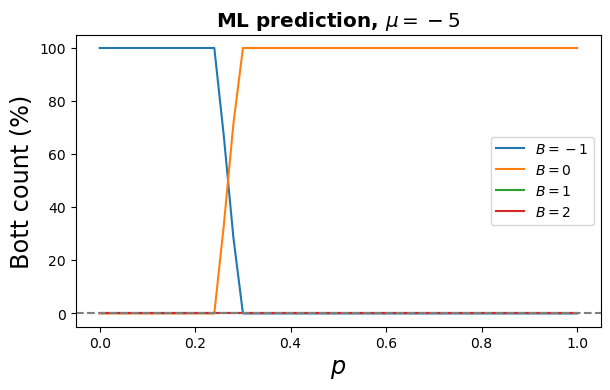

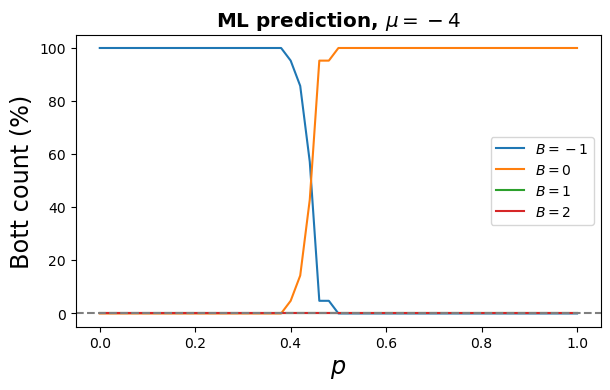

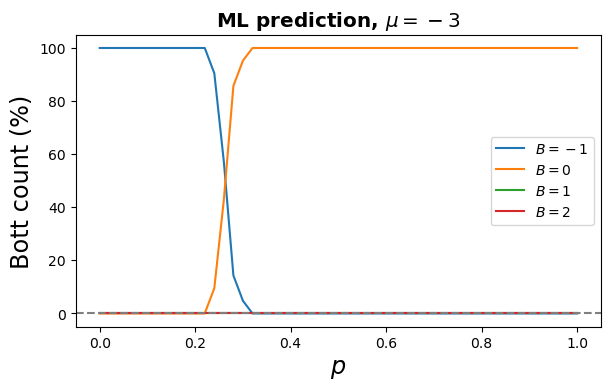

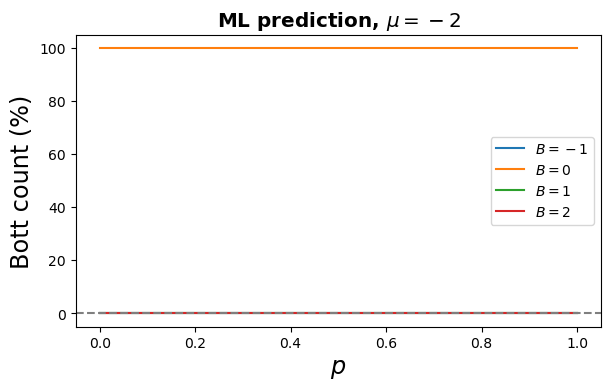

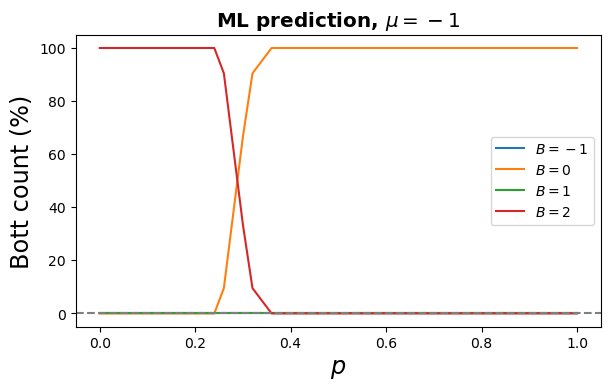

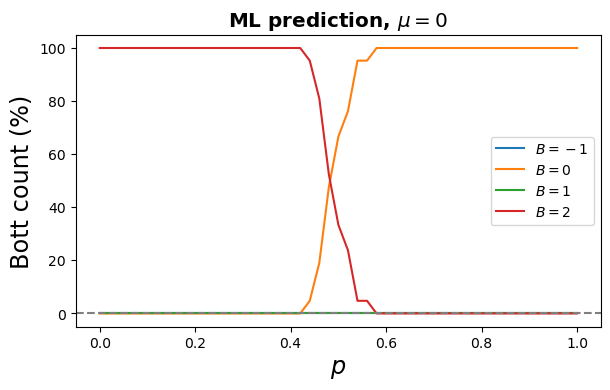

In [5]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=1000).fit(X_train, y_train)

Bott_density,Bott_all=Predict_Classification(model,X_test,y_test) 
Plots(Bott_density,Bott_all)

The result with RandomForest is better than the one using LogisticRegression.

## Train a deep learning model

Next we use tensorflow to train different deep neural network (DNN) models. We start by considering the case with no hidden neuron layer.

2023-12-07 20:52:52.071359: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-07 20:52:52.134941: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-07 20:52:52.134991: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-07 20:52:52.136337: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-07 20:52:52.145005: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-07 20:52:52.145783: I tensorflow/core/platform/cpu_feature_guard.cc:1

Epoch 1/25


2023-12-07 20:52:57.551297: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 615196800 exceeds 10% of free system memory.


17073/17089 [============================>.] - ETA: 0s - loss: 0.2286 - accuracy: 0.9406

2023-12-07 20:53:40.599373: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 273747600 exceeds 10% of free system memory.


17089/17089 [==============================] - 55s 3ms/step - loss: 0.2285 - accuracy: 0.9406 - val_loss: 0.1518 - val_accuracy: 0.9551
Epoch 2/25
17089/17089 [==============================] - 54s 3ms/step - loss: 0.1423 - accuracy: 0.9570 - val_loss: 0.1387 - val_accuracy: 0.9604
Epoch 3/25
17089/17089 [==============================] - 62s 4ms/step - loss: 0.1324 - accuracy: 0.9598 - val_loss: 0.1298 - val_accuracy: 0.9604
Epoch 4/25
17089/17089 [==============================] - 54s 3ms/step - loss: 0.1275 - accuracy: 0.9611 - val_loss: 0.1263 - val_accuracy: 0.9610
Epoch 5/25
17089/17089 [==============================] - 54s 3ms/step - loss: 0.1242 - accuracy: 0.9621 - val_loss: 0.1235 - val_accuracy: 0.9630
Epoch 6/25
17089/17089 [==============================] - 54s 3ms/step - loss: 0.1214 - accuracy: 0.9629 - val_loss: 0.1220 - val_accuracy: 0.9620
Epoch 7/25
17089/17089 [==============================] - 54s 3ms/step - loss: 0.1193 - accuracy: 0.9633 - val_loss: 0.1196 - val

2023-12-07 21:15:48.160867: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 273747600 exceeds 10% of free system memory.


  54/2377 [..............................] - ETA: 4s

2023-12-07 21:15:54.971805: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 273747600 exceeds 10% of free system memory.


2377/2377 [==============================] - 5s 2ms/step


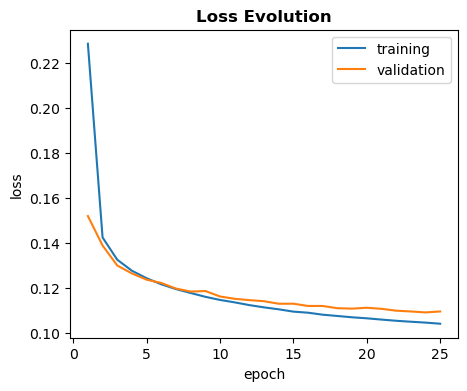

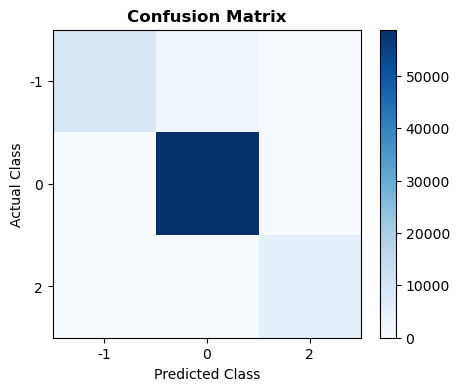

In [6]:
#Change data format to classes [0,1,2]:
y_train=np.where(y_t==0,1,y_t)
y_train=np.where(y_train==-1,0,y_train)
y_test=np.where(y_test==0,1,y_test)
y_test=np.where(y_test==-1,0,y_test)

X_train = X_train.astype('float32') 
X_test = X_test.astype('float32') 

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers
from sklearn.model_selection import train_test_split

n_features=len(X_train[0,:]) # Number of features


#No hidden layer
model = Sequential()
model.add(Dense(3, input_dim=n_features, activation='softmax')) 

learning_rate2 = 0.001 #hyper-parameters for optimizer
num_epochs = 25 
batch_size2=10
opt = optimizers.Adam(learning_rate=learning_rate2)
model.compile(loss='sparse_categorical_crossentropy',optimizer=opt,metrics=['accuracy']) 
history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size2, validation_data=(X_test, y_test)) 



def Predict_DNN(model2,X_test2,y_test2):
    
    class_probabilities=model2.predict(X_test2)
    predictions=np.argmax(class_probabilities, axis=1)
    
    # Plot the Loss Evolution
    plt.figure(figsize=(5,4))
    epoch_nums = range(1,num_epochs+1)
    training_loss = history.history["loss"]
    validation_loss = history.history["val_loss"]
    plt.plot(epoch_nums, training_loss)
    plt.plot(epoch_nums, validation_loss)
    plt.title('Loss Evolution', fontweight ="bold",loc='center')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['training', 'validation'], loc='upper right')
    plt.savefig('Data/g1.png')
    
    # Plot the Confusion Matrix
    from sklearn.metrics import confusion_matrix
    classes=['-1','0','2']
    plt.figure(figsize=(5,4))
    cm = confusion_matrix(y_test2, predictions)
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)
    plt.title('Confusion Matrix', fontweight ="bold",loc='center')
    plt.xlabel("Predicted Class")
    plt.ylabel("Actual Class")
    plt.savefig('Data/g2.png')
    
    #Next we make predictions with the model:
    Bott_all2=np.zeros((N_mu,N_p,N_d)) 
    Bott_density2=np.zeros((N_mu,N_p)) 
    Bott_class = model2.predict(X_test2.astype('float32')) 
 
    for i_mu,mu_i in enumerate(np.unique(mu_test)):
        for i_p,p_i in  enumerate(np.unique(p_test)):
            var=np.intersect1d(np.where(mu_test==mu_i),np.where(p_test==p_i))
            Bott_t=np.argmax(Bott_class[var], axis=1)
            Bott_t=np.where(Bott_t==0,-1,Bott_t)#Change format from classes to actual Bott index.
            Bott_t=np.where(Bott_t==1,0,Bott_t)
            Bott_density2[i_mu,i_p]=Bott_t.mean()
            Bott_all2[i_mu,i_p,:]=Bott_t[:]

    return Bott_density2,Bott_all2

Bott_density,Bott_all=Predict_DNN(model,X_test,y_test)

We see that the losses of the training and validation data are decreasing with the number of epochs. The model is not overfitting to the training set. However, its accuracy is lower than the RandomForest method. Let us see the predictions.

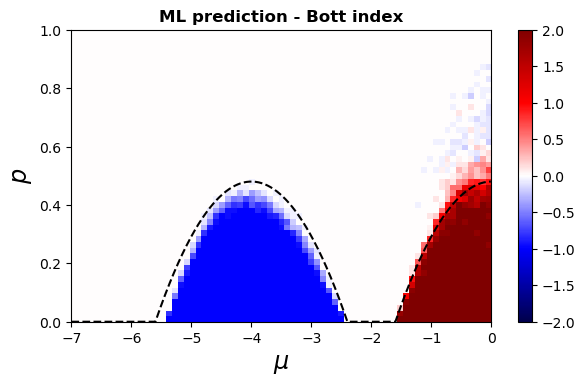

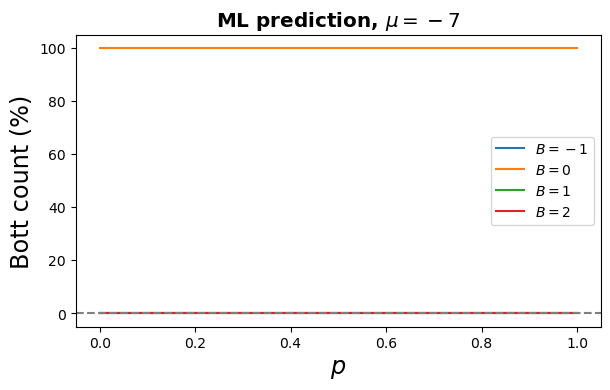

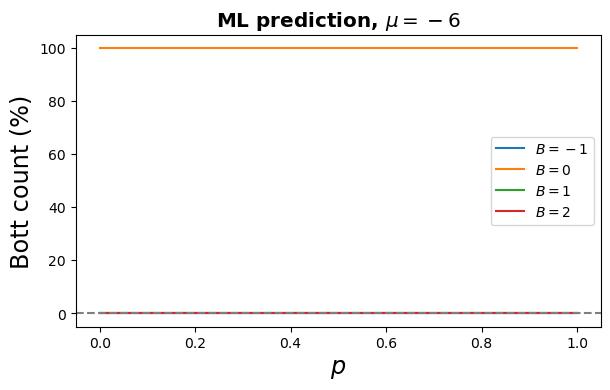

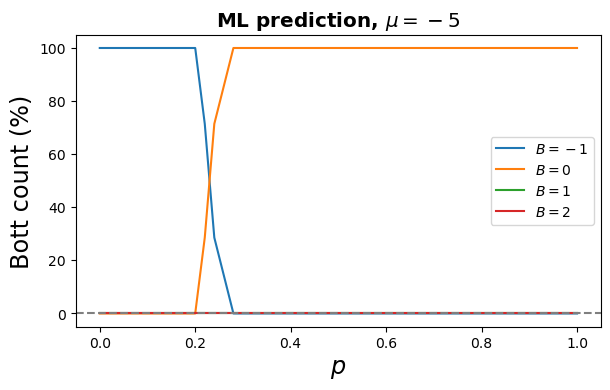

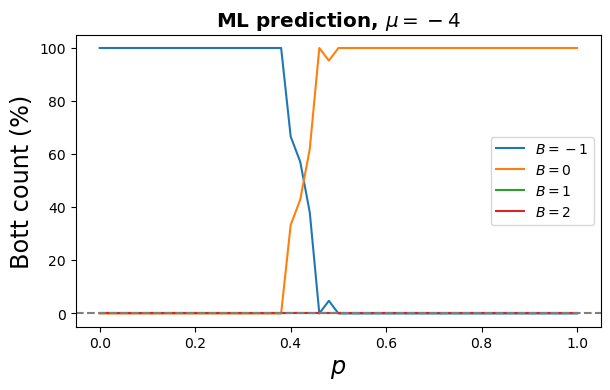

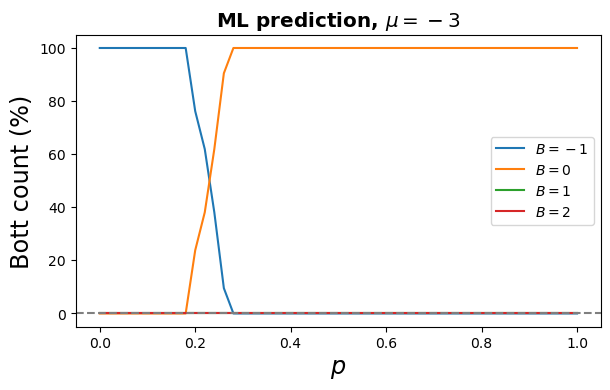

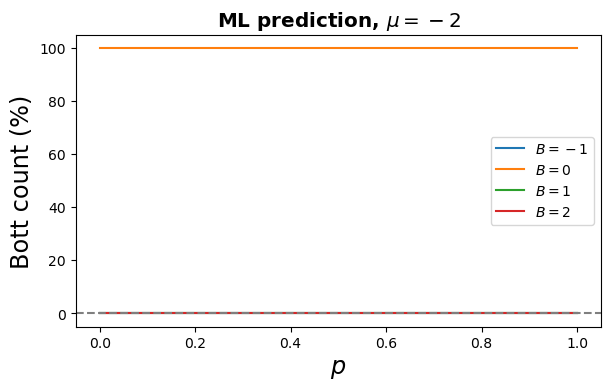

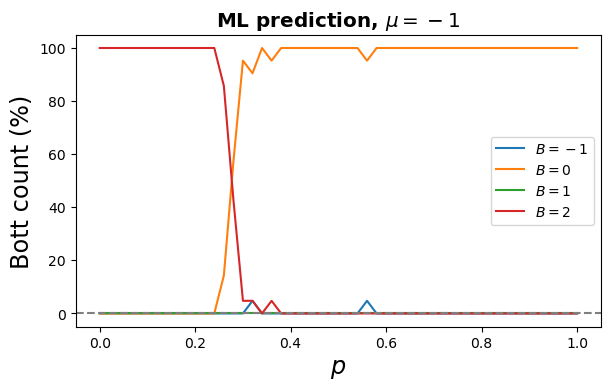

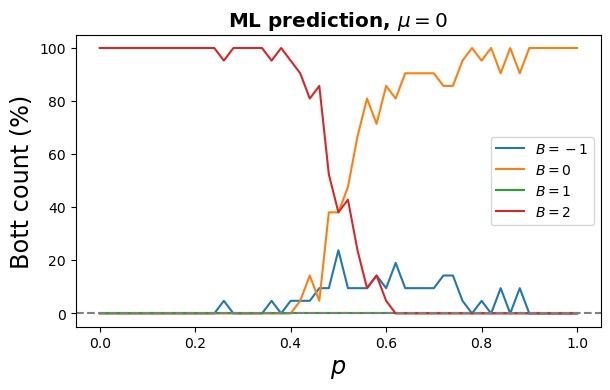

In [7]:
Plots(Bott_density,Bott_all)

The model predicted the Bott index to be B=-1 in regions it should be B=0 and vice versa. Let's try to improve the model increasing the number of epochs.

Epoch 1/100


2023-12-07 21:16:07.280556: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 615196800 exceeds 10% of free system memory.


17089/17089 [==============================] - 55s 3ms/step - loss: 0.2289 - accuracy: 0.9410 - val_loss: 0.1515 - val_accuracy: 0.9551
Epoch 2/100
17089/17089 [==============================] - 54s 3ms/step - loss: 0.1423 - accuracy: 0.9573 - val_loss: 0.1357 - val_accuracy: 0.9589
Epoch 3/100
17089/17089 [==============================] - 54s 3ms/step - loss: 0.1324 - accuracy: 0.9597 - val_loss: 0.1299 - val_accuracy: 0.9613
Epoch 4/100
17089/17089 [==============================] - 54s 3ms/step - loss: 0.1273 - accuracy: 0.9613 - val_loss: 0.1259 - val_accuracy: 0.9617
Epoch 5/100
17089/17089 [==============================] - 55s 3ms/step - loss: 0.1241 - accuracy: 0.9620 - val_loss: 0.1233 - val_accuracy: 0.9627
Epoch 6/100
17089/17089 [==============================] - 63s 4ms/step - loss: 0.1212 - accuracy: 0.9630 - val_loss: 0.1213 - val_accuracy: 0.9633
Epoch 7/100
17089/17089 [==============================] - 54s 3ms/step - loss: 0.1193 - accuracy: 0.9635 - val_loss: 0.1215

17089/17089 [==============================] - 54s 3ms/step - loss: 0.0982 - accuracy: 0.9693 - val_loss: 0.1070 - val_accuracy: 0.9676
Epoch 57/100
17089/17089 [==============================] - 54s 3ms/step - loss: 0.0980 - accuracy: 0.9695 - val_loss: 0.1069 - val_accuracy: 0.9678
Epoch 58/100
17089/17089 [==============================] - 54s 3ms/step - loss: 0.0979 - accuracy: 0.9695 - val_loss: 0.1076 - val_accuracy: 0.9669
Epoch 59/100
17089/17089 [==============================] - 54s 3ms/step - loss: 0.0978 - accuracy: 0.9694 - val_loss: 0.1072 - val_accuracy: 0.9680
Epoch 60/100
17089/17089 [==============================] - 54s 3ms/step - loss: 0.0977 - accuracy: 0.9694 - val_loss: 0.1070 - val_accuracy: 0.9677
Epoch 61/100
17089/17089 [==============================] - 54s 3ms/step - loss: 0.0976 - accuracy: 0.9695 - val_loss: 0.1076 - val_accuracy: 0.9676
Epoch 62/100
17089/17089 [==============================] - 54s 3ms/step - loss: 0.0976 - accuracy: 0.9696 - val_loss: 

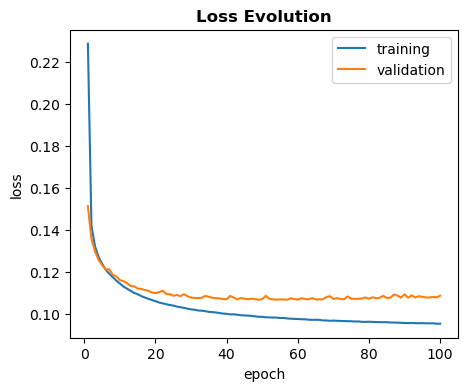

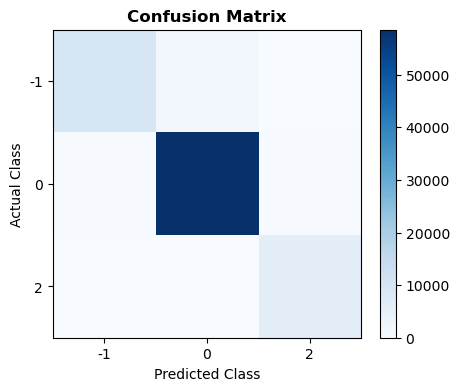

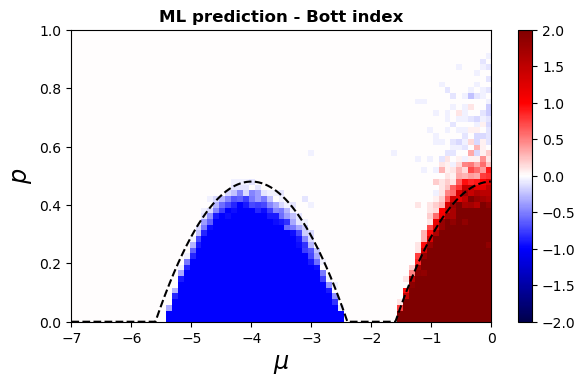

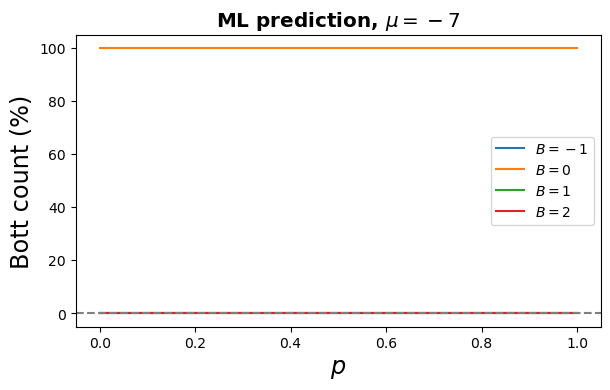

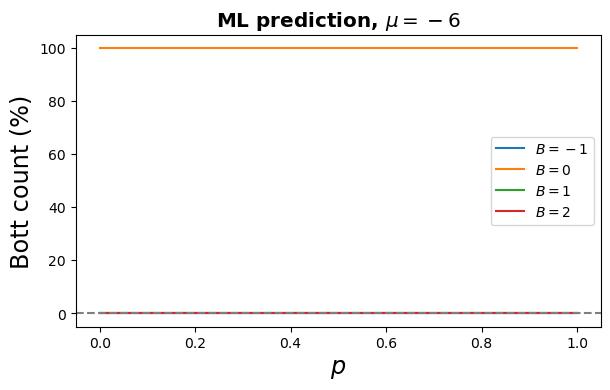

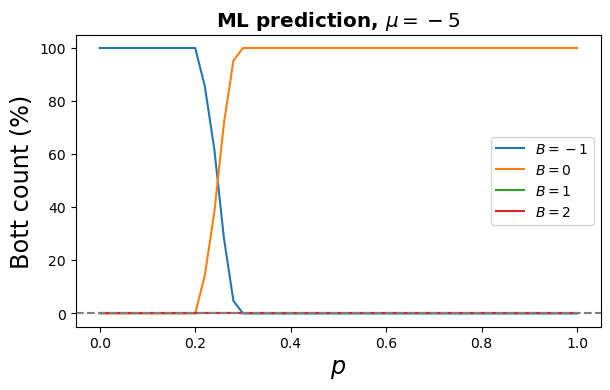

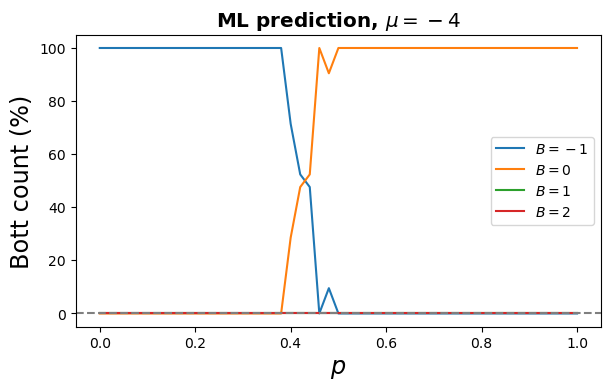

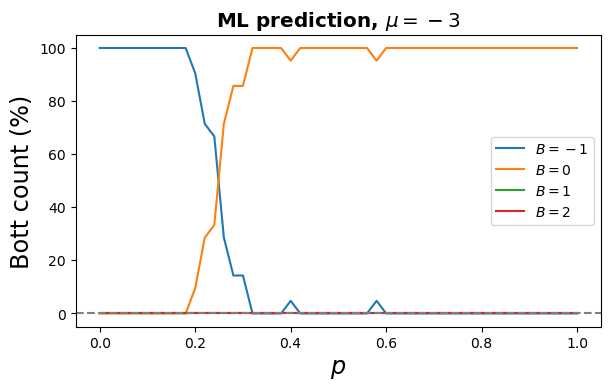

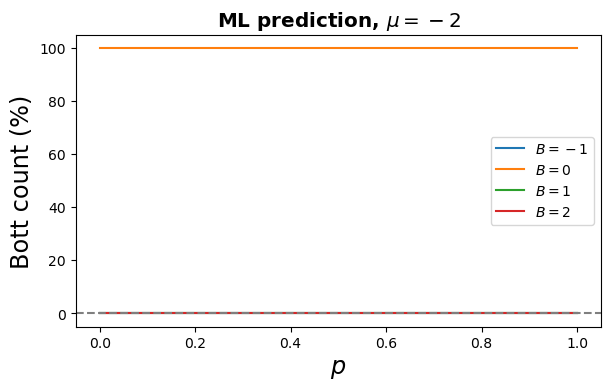

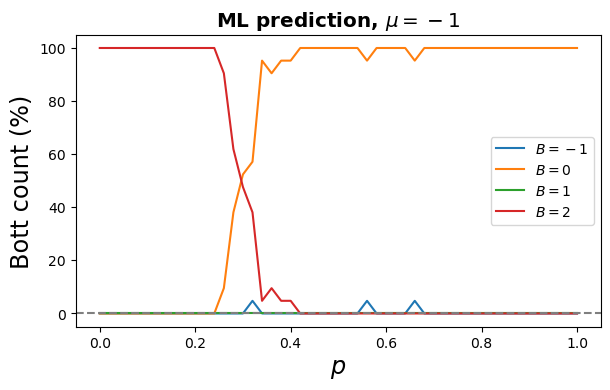

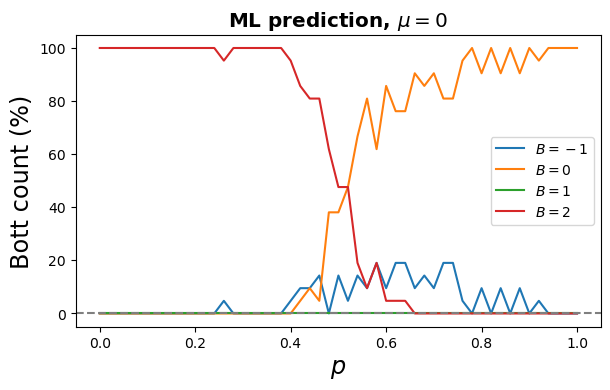

In [8]:
#No hidden layer and more epochs
model = Sequential()
model.add(Dense(3, input_dim=n_features, activation='softmax')) 

num_epochs = 100 
opt = optimizers.Adam(learning_rate=learning_rate2)
model.compile(loss='sparse_categorical_crossentropy',optimizer=opt,metrics=['accuracy']) 
history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size2, validation_data=(X_test, y_test)) 

Bott_density,Bott_all=Predict_DNN(model,X_test,y_test) 
Plots(Bott_density,Bott_all)

We did not obtain a better result with more epochs. In the following we check if we are able to obtain a better result considering one hidden layer of neurons. Hidden neuron layers are able to capture nonlinear correlations between the labels and the features.

Epoch 1/25
17089/17089 [==============================] - 228s 13ms/step - loss: 0.0740 - accuracy: 0.9733 - val_loss: 0.0458 - val_accuracy: 0.9819
Epoch 2/25
17089/17089 [==============================] - 226s 13ms/step - loss: 0.0480 - accuracy: 0.9807 - val_loss: 0.0663 - val_accuracy: 0.9735
Epoch 3/25
17089/17089 [==============================] - 227s 13ms/step - loss: 0.0424 - accuracy: 0.9828 - val_loss: 0.0470 - val_accuracy: 0.9812
Epoch 4/25
17089/17089 [==============================] - 227s 13ms/step - loss: 0.0392 - accuracy: 0.9840 - val_loss: 0.0371 - val_accuracy: 0.9841
Epoch 5/25
17089/17089 [==============================] - 228s 13ms/step - loss: 0.0367 - accuracy: 0.9851 - val_loss: 0.0443 - val_accuracy: 0.9822
Epoch 6/25
17089/17089 [==============================] - 228s 13ms/step - loss: 0.0350 - accuracy: 0.9858 - val_loss: 0.0415 - val_accuracy: 0.9836
Epoch 7/25
17089/17089 [==============================] - 228s 13ms/step - loss: 0.0342 - accuracy: 0.9859

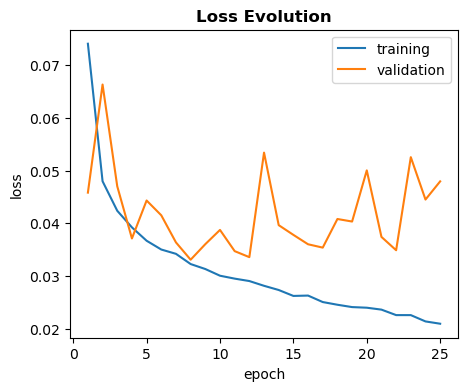

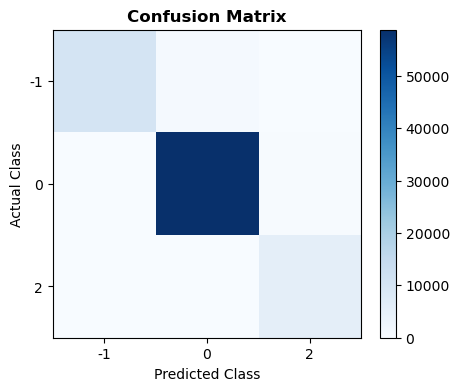

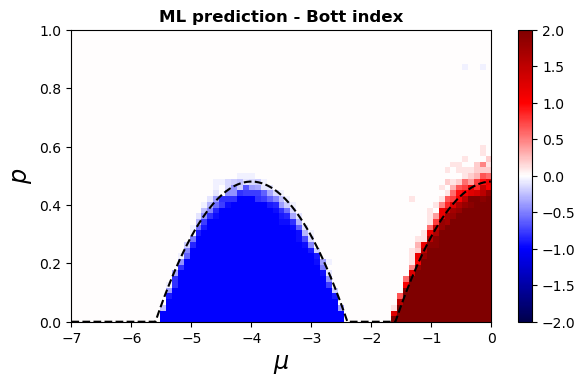

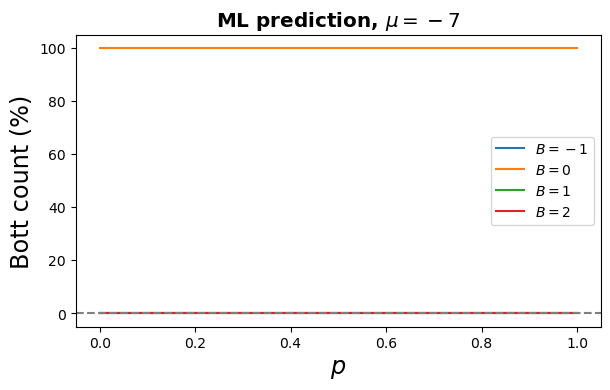

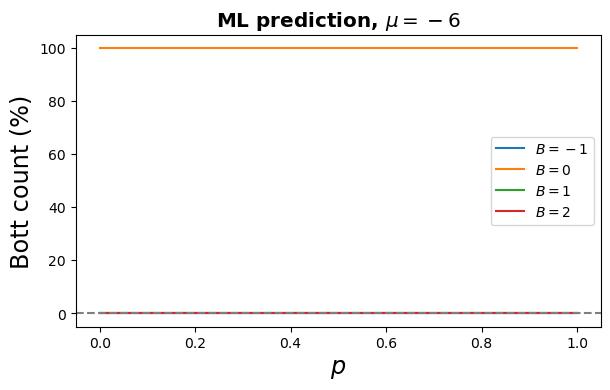

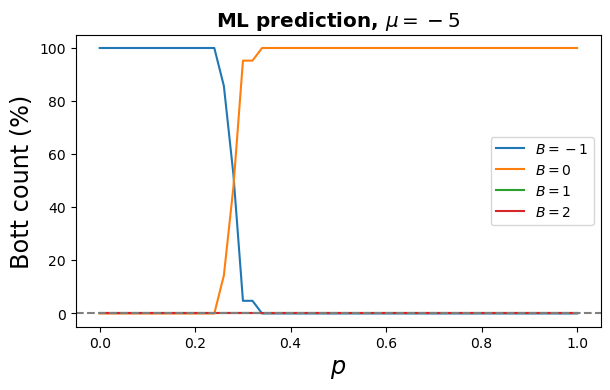

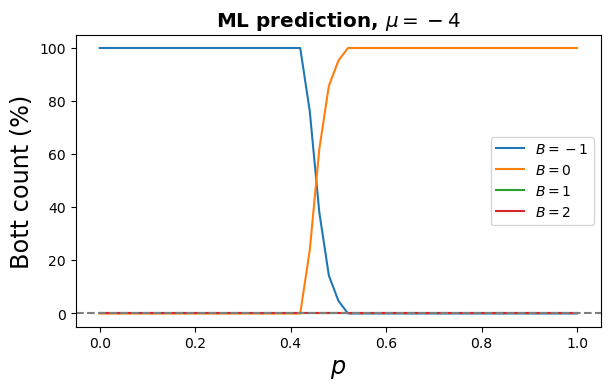

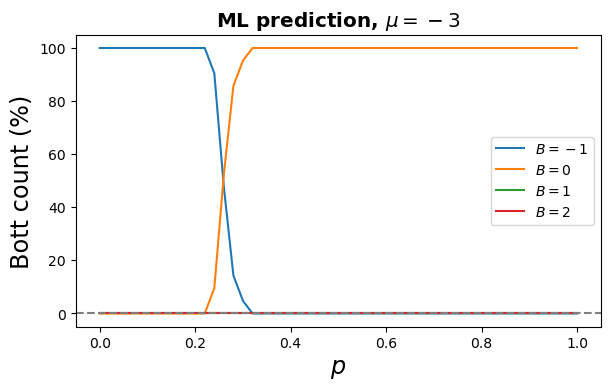

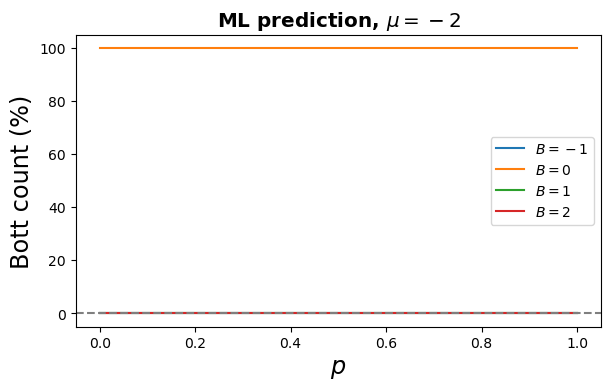

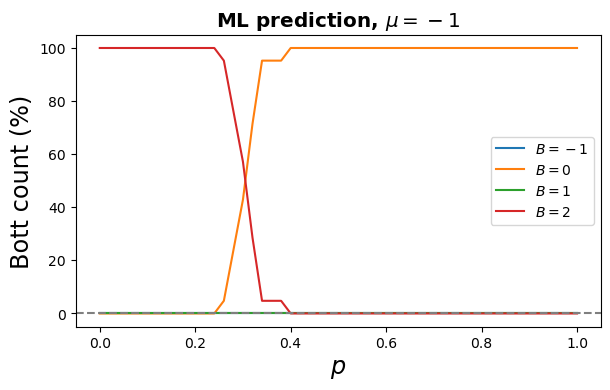

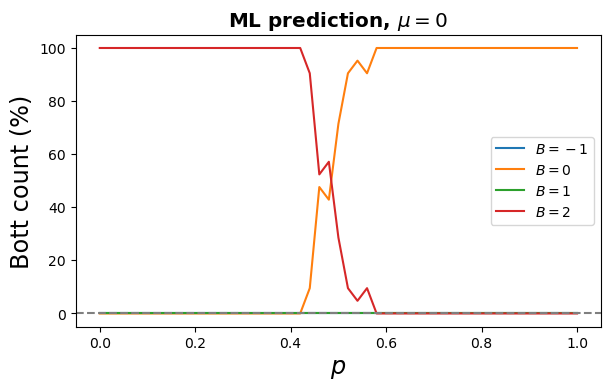

In [9]:
#One hidden layer
hl = int(2*n_features/3) # Number of hidden layer nodes
model = Sequential()
model.add(Dense(hl, input_dim=n_features, activation='relu')) 
model.add(Dense(3, input_dim=hl, activation='softmax'))

num_epochs = 25 
opt = optimizers.Adam(learning_rate=learning_rate2)
model.compile(loss='sparse_categorical_crossentropy',optimizer=opt,metrics=['accuracy']) 
history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size2, validation_data=(X_test, y_test)) 

Bott_density,Bott_all=Predict_DNN(model,X_test,y_test) 
Plots(Bott_density,Bott_all)


Now the resul is better and the accuracy is closer to 1. Let's see the result with more epochs.

Epoch 1/100
17089/17089 [==============================] - 227s 13ms/step - loss: 0.0734 - accuracy: 0.9741 - val_loss: 0.0498 - val_accuracy: 0.9794
Epoch 2/100
17089/17089 [==============================] - 226s 13ms/step - loss: 0.0470 - accuracy: 0.9809 - val_loss: 0.0539 - val_accuracy: 0.9795
Epoch 3/100
17089/17089 [==============================] - 227s 13ms/step - loss: 0.0415 - accuracy: 0.9832 - val_loss: 0.0393 - val_accuracy: 0.9843
Epoch 4/100
17089/17089 [==============================] - 226s 13ms/step - loss: 0.0387 - accuracy: 0.9840 - val_loss: 0.0426 - val_accuracy: 0.9821
Epoch 5/100
17089/17089 [==============================] - 226s 13ms/step - loss: 0.0367 - accuracy: 0.9852 - val_loss: 0.0375 - val_accuracy: 0.9846
Epoch 6/100
17089/17089 [==============================] - 225s 13ms/step - loss: 0.0352 - accuracy: 0.9855 - val_loss: 0.0718 - val_accuracy: 0.9728
Epoch 7/100
17089/17089 [==============================] - 225s 13ms/step - loss: 0.0340 - accuracy:

17089/17089 [==============================] - 254s 15ms/step - loss: 0.0119 - accuracy: 0.9954 - val_loss: 0.0822 - val_accuracy: 0.9839
Epoch 56/100
17089/17089 [==============================] - 250s 15ms/step - loss: 0.0120 - accuracy: 0.9954 - val_loss: 0.0731 - val_accuracy: 0.9834
Epoch 57/100
17089/17089 [==============================] - 254s 15ms/step - loss: 0.0117 - accuracy: 0.9955 - val_loss: 0.0677 - val_accuracy: 0.9855
Epoch 58/100
17089/17089 [==============================] - 255s 15ms/step - loss: 0.0115 - accuracy: 0.9955 - val_loss: 0.0592 - val_accuracy: 0.9856
Epoch 59/100
17089/17089 [==============================] - 253s 15ms/step - loss: 0.0112 - accuracy: 0.9956 - val_loss: 0.0723 - val_accuracy: 0.9845
Epoch 60/100
17089/17089 [==============================] - 334s 20ms/step - loss: 0.0116 - accuracy: 0.9956 - val_loss: 0.0588 - val_accuracy: 0.9860
Epoch 61/100
17089/17089 [==============================] - 336s 20ms/step - loss: 0.0110 - accuracy: 0.995

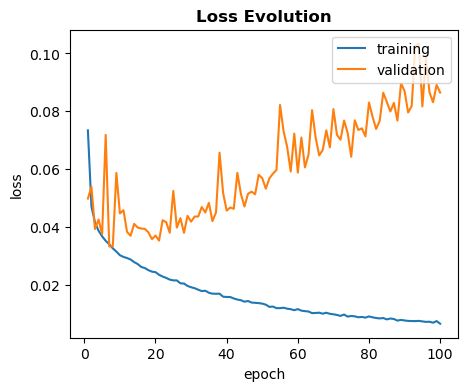

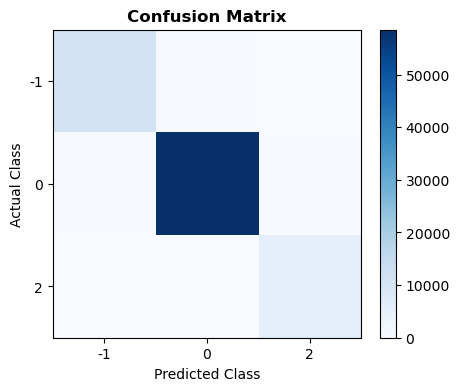

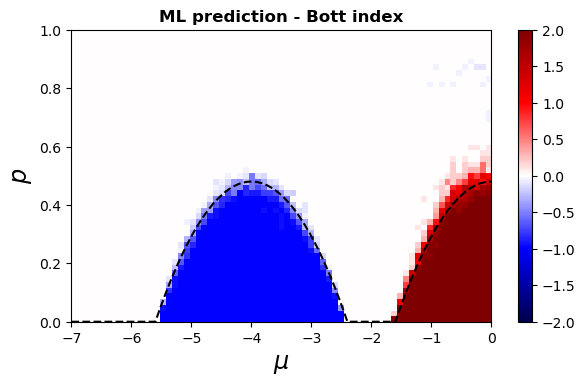

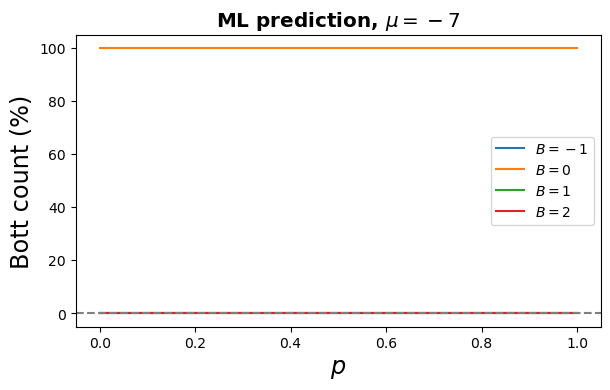

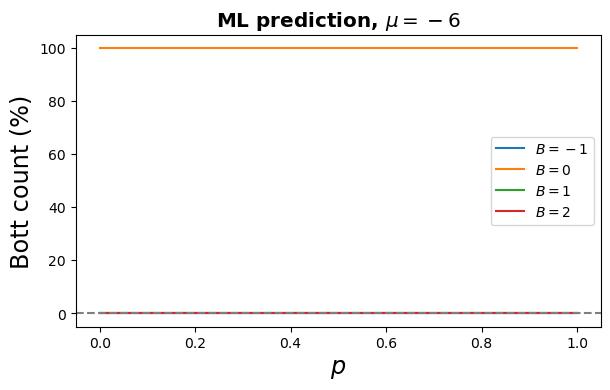

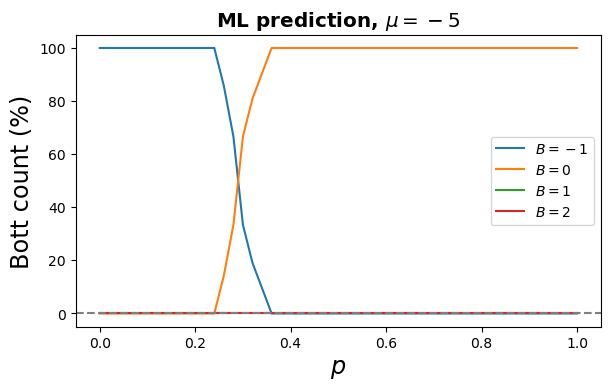

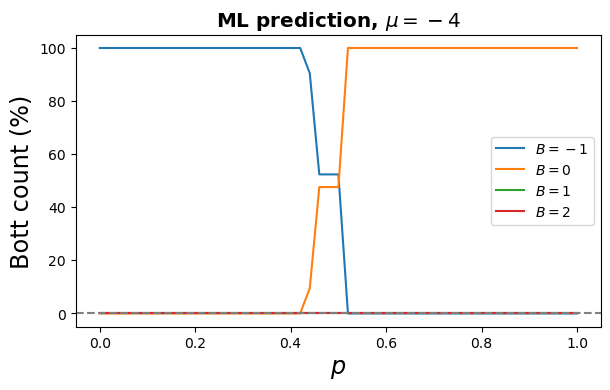

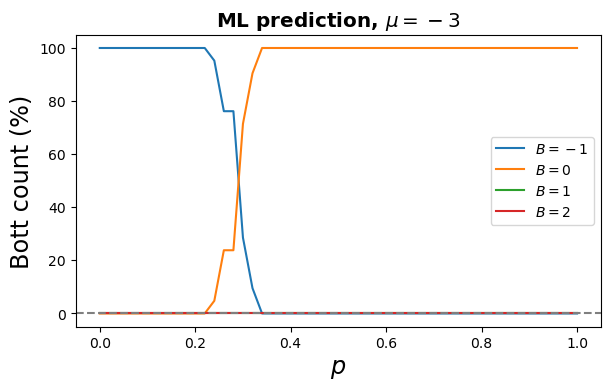

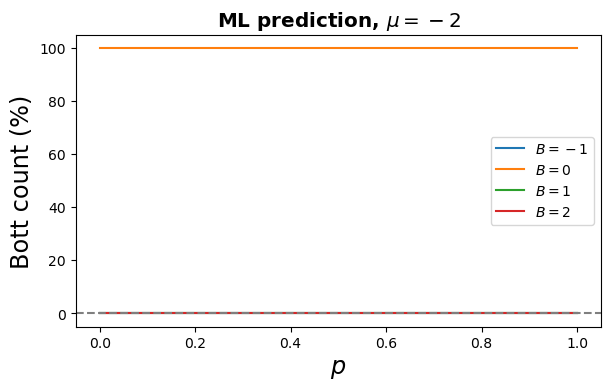

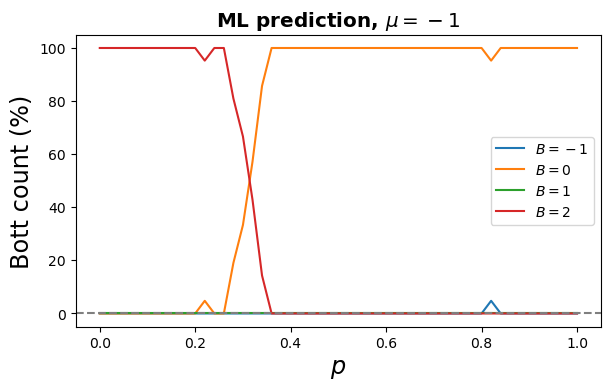

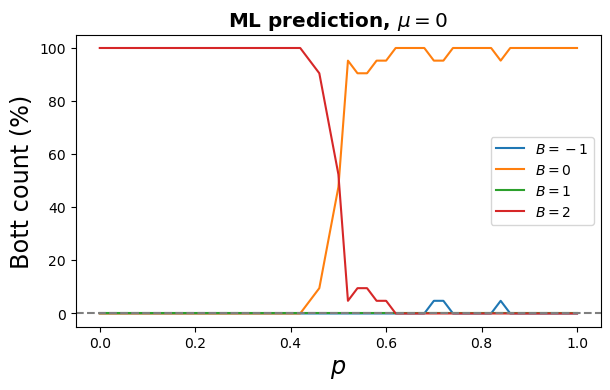

In [10]:
#One hidden layer and more epochs
hl = int(2*n_features/3) # Number of hidden layer nodes
model = Sequential()
model.add(Dense(hl, input_dim=n_features, activation='relu')) 
model.add(Dense(3, input_dim=hl, activation='softmax'))

num_epochs = 100 
opt = optimizers.Adam(learning_rate=learning_rate2)
model.compile(loss='sparse_categorical_crossentropy',optimizer=opt,metrics=['accuracy']) 
history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size2, validation_data=(X_test, y_test)) 

Bott_density,Bott_all=Predict_DNN(model,X_test,y_test) 
Plots(Bott_density,Bott_all)

Again the result was not improved using more epochs and now the validation loss is slowly increasing, suggesting some overfitting. We consider two hidden neuron layers in the following.

Epoch 1/25
17089/17089 [==============================] - 537s 31ms/step - loss: 0.0703 - accuracy: 0.9738 - val_loss: 0.0460 - val_accuracy: 0.9808
Epoch 2/25
17089/17089 [==============================] - 571s 33ms/step - loss: 0.0462 - accuracy: 0.9813 - val_loss: 0.0395 - val_accuracy: 0.9824
Epoch 3/25
17089/17089 [==============================] - 536s 31ms/step - loss: 0.0410 - accuracy: 0.9835 - val_loss: 0.0558 - val_accuracy: 0.9771
Epoch 4/25
17089/17089 [==============================] - 538s 31ms/step - loss: 0.0380 - accuracy: 0.9844 - val_loss: 0.0358 - val_accuracy: 0.9851
Epoch 5/25
17089/17089 [==============================] - 504s 29ms/step - loss: 0.0354 - accuracy: 0.9856 - val_loss: 0.0418 - val_accuracy: 0.9813
Epoch 6/25
17089/17089 [==============================] - 537s 31ms/step - loss: 0.0344 - accuracy: 0.9856 - val_loss: 0.0358 - val_accuracy: 0.9855
Epoch 7/25
17089/17089 [==============================] - 537s 31ms/step - loss: 0.0334 - accuracy: 0.9860

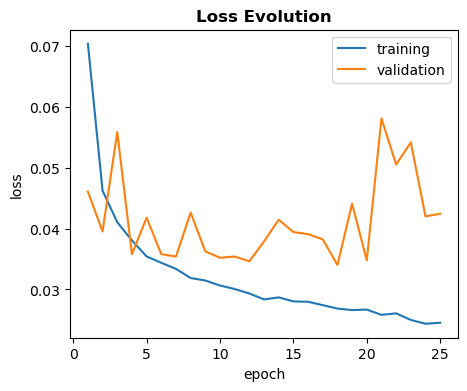

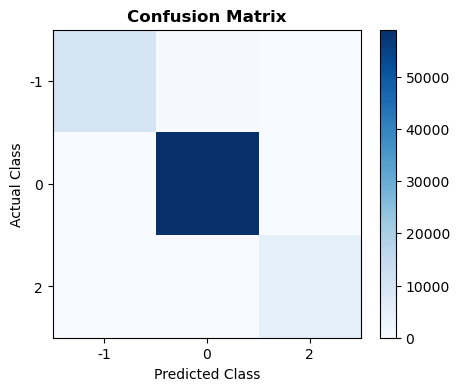

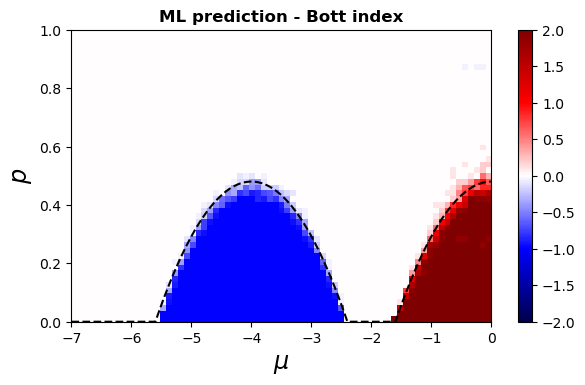

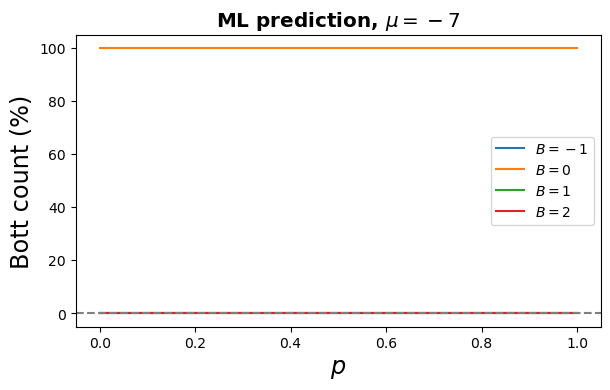

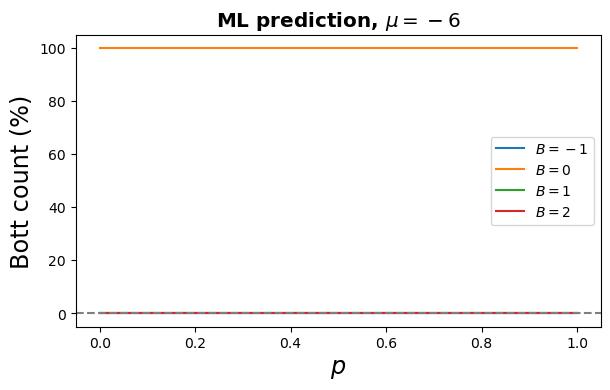

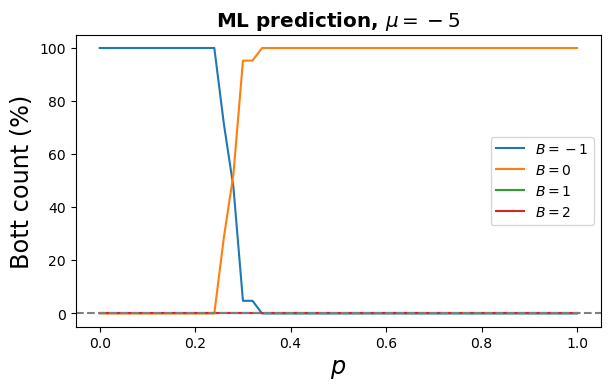

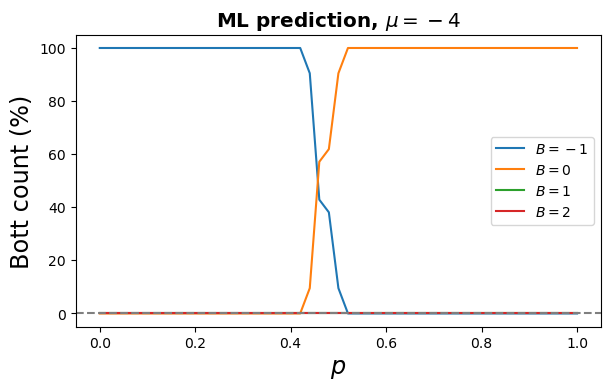

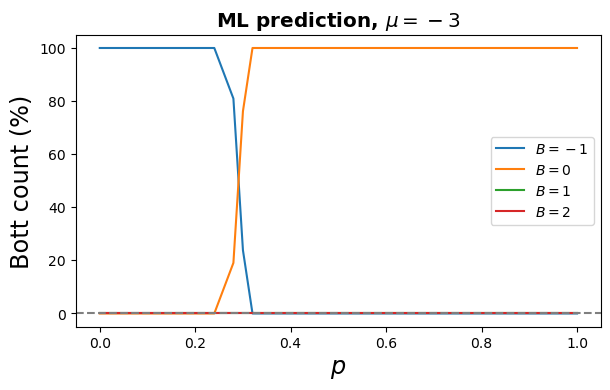

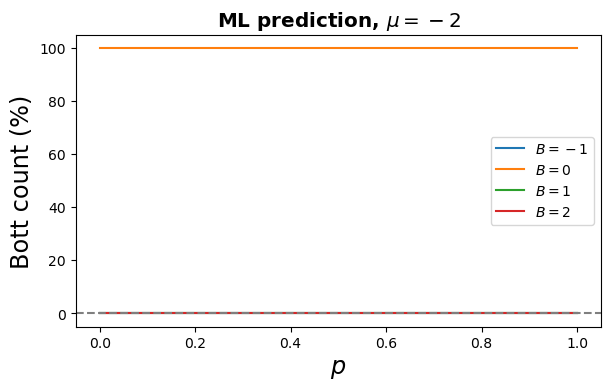

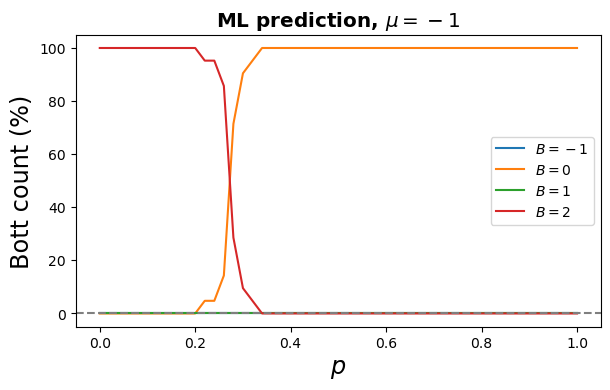

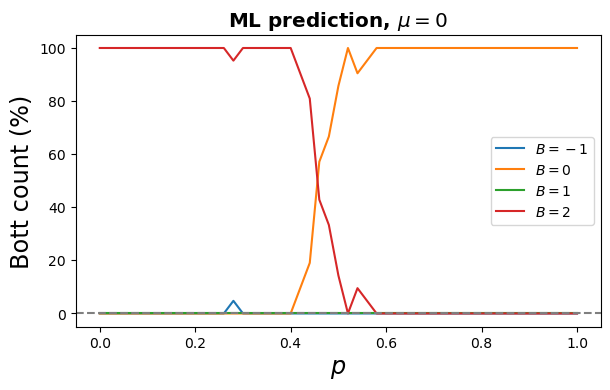

In [11]:
#Two hidden layers
hl = int(2*n_features/3) # Number of hidden layer nodes
model = Sequential()
model.add(Dense(hl, input_dim=n_features, activation='relu')) 
model.add(Dense(hl, input_dim=hl, activation='relu'))
model.add(Dense(3, input_dim=hl, activation='softmax'))

num_epochs = 25 
opt = optimizers.Adam(learning_rate=learning_rate2)
model.compile(loss='sparse_categorical_crossentropy',optimizer=opt,metrics=['accuracy']) 
history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size2, validation_data=(X_test, y_test)) 

Bott_density,Bott_all=Predict_DNN(model,X_test,y_test) 
Plots(Bott_density,Bott_all)

This model has accuracy of 0.99 and displays the best result. Let us save it for future use.

In [13]:
# SAVE OR LOAD MODEL
modelFileName = 'Data/classifier_DNN.keras'
model.save(modelFileName)
# from tensorflow.keras import models
# model = models.load_model(modelFileName)

## Conclusion

Here we trained ML models to predict the topological Bott index of disordered superconductors. We fully recovered the phase diagram of B as a function of mu and p using different ML methods. The best method was based on neural networks with two hidden layers, indicating that there is some amount of nonlinear correlation between labels and features. The precise calculation of the Bott index demands high computational resources and we are able to make faster accurate predictions of this topological index using ML methods, which require less computational resources.